# Customer Life Value Optimization Model
Goal: Develop a model using A/B testing to strategise discount targeting for maximised Customer Life Value (CLV)

#### Importing Packages

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

print("Packages imported successfully!")

#### Importing the data

In [ ]:
# Removing index, and customer ID columns
# We use the encoded data, not normalized; we only want the features normal, not the output
data = pd.read_csv("data/data_encoded.csv").drop(columns=["Unnamed: 0", "Customer ID"])

data.head()

In [ ]:
data.info()

## Feature Engineering

#### Creating Interaction Terms

Before continuing, there are vital insights from the ETL script that we must acknowledge prior to modelling:
- Customers' Genders are (mostly) segregated by City
- Whether or not a customer receieved a Discount is entirely based on City

Because of this, *City* must be treated as a *confounding variable*

In [ ]:
data = pd.read_csv("data/data_raw.csv").drop(columns=[ "Customer ID"])
# Creating interaction terms between interaction features
cat_vars = ['City', 'Gender', 'Discount Applied', 'Membership Type', 'Satisfaction Level']

# Apply OneHotEncoder
encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded_cats = encoder.fit_transform(data[cat_vars])
encoded_cat_names = encoder.get_feature_names_out(cat_vars)
encoded_df = pd.DataFrame(encoded_cats, columns=encoded_cat_names) # Dropping a col that has 0 vals
data_enc = pd.concat([data, encoded_df], axis=1).drop(columns=cat_vars) # Dropping the non-encoded columns
encoded_df.head()


#### Feature Scaling

In [ ]:
numerical_features = ["Age", "Items Purchased", "Days Since Last Purchase"]
data_scaled = data_enc.copy()
scaler = StandardScaler()

data_scaled[numerical_features] = scaler.fit_transform(data_scaled[numerical_features])
data_scaled[numerical_features].head()

#### Interaction Terms

There are two major things to note here:

- **City**: It seems as though their Discount program was targeted by City, not by customer. We will have to keep this in mind when constructing models. Further, it does not seem as though, based on City alone, there was a strong effect of applying a discount; however, we cannot compare as we do not have independent data points.
- **Gender**: Discounts were much more heavily applied to Female customers as compared to Male.

We will create interaction terms to account for this

In [ ]:
# Using the OneHotEncoded columns + Rating and Age to create interactions
interaction_features = encoded_cat_names.tolist() + ['Average Rating', 'Age']
poly = PolynomialFeatures(interaction_only=True, include_bias=False)
interaction_terms = poly.fit_transform(data_scaled[interaction_features])

# Convert interaction terms to DataFrame and add to the main data
interaction_term_names = poly.get_feature_names_out(interaction_features)
interaction_df = pd.DataFrame(interaction_terms, columns=interaction_term_names)

data_interaction = pd.concat([data_scaled, interaction_df], axis=1)
data_interaction.head()

#### Base Model Selection

##### Train Test Split

In [ ]:
def data_prep(data, lasso = True, view_features = False, alpha=0.01):
    """
    Function to split the data and, optionally, regularize and view regularization outputs.
    
    Parameters:
    - data: DataFrame containing the dataset.
    - lasso: Boolean flag to indicate whether Lasso regularization should be applied.
    - view_features: Boolean flag to print selected features and coefficients.
    - alpha: The alpha parameter for the Lasso regularization.
    
    Returns:
    X_train, X_test, y_train, y_test
    """
    # Initialize features (X) and target variable (y)
    X = data.drop(columns=['Total Spend'])  # Assuming 'Total Spend' is the target variable
    y = data['Total Spend']

    if lasso:
        # Initialize the Lasso model with the specified alpha
        lasso_model = Lasso(alpha=alpha, random_state=42)

        # Fit the Lasso model to the data
        lasso_model.fit(X, y)

        # Identify the features with non-zero coefficients
        selected_features = X.columns[lasso_model.coef_ != 0]
        
        if view_features:
            print("Selected Features:", selected_features.tolist())
            print("Lasso Coefficients:", lasso_model.coef_)

        # Select only the features with non-zero coefficients
        X = X[selected_features]

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    return X_train, X_test, y_train, y_test

The following dictionary are the base models we will be testing

In [ ]:
models = {
    LinearRegression(): "Linear Regression",
    RandomForestRegressor(random_state=42): "Random Forest Regression",
    GradientBoostingRegressor(random_state=42): "Gradient Boosting Regressor"
}

#### Model Selection

In [ ]:
def model_selection(models=models, data=data, lasso=True, alpha = 0.01):
    """This function allows testing different models and data
        Utilises the previously made data_prep function"""
    X_train, X_test, y_train, y_test = data_prep(data=data, lasso=lasso, alpha = alpha)
    for model, name in models.items():
        # Train the model
        model.fit(X_train, y_train)
        
        # Predict on the test set
        y_pred = model.predict(X_test)
        
        # Calculate performance metrics
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        rmse = mse ** 0.5
        
        # Print model performance
        print(f"Model: {name}")
        print(f"Mean Squared Error: {mse:.2f}")
        print(f"Root Mean Squared Error: {rmse:.2f}")
        print(f"R-squared: {r2:.2f}\n")
        


##### Test 1: Encoded Data (Without Interaction Terms)

In [ ]:
model_selection(data = data_enc, lasso = True)

##### Test 2: Encoded, Scaled Data (Without Interaction Terms)

In [ ]:
model_selection(data = data_scaled, lasso = True)

##### Test 3: Encoded, Scaled Data (With Interaction Terms)

In [ ]:
model_selection(data = data_interaction, lasso = True, alpha = 0.9)

Judging by the RMSE and R-squared values, we will continue with the GBR (Gradience Boosting Regressor), using the scaled, encoded data with interaction terms.

#### Hyperparameter Tuning

##### Testing different alphas

In [ ]:
alphas = np.arange(0.05,1,0.01)
alpha_scores = {}
for alpha in alphas:
    X_train, X_test, y_train, y_test = data_prep(data=data_interaction, lasso=True, alpha = alpha)
    model = GradientBoostingRegressor(random_state=42)
    model.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = model.predict(X_test)
    
    # Calculate performance metrics
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    rmse = mse ** 0.5
    
    # Print model performance
    print(f"Alpha: {alpha}")
    print(f"Mean Squared Error: {mse:.2f}")
    print(f"Root Mean Squared Error: {rmse:.2f}")
    print(f"R-squared: {r2:.2f}\n")

    alpha_scores[alpha]=rmse

In [ ]:
sns.lineplot(alpha_scores)
plt.xlabel("Alpha")
plt.ylabel("RMSE")
plt.title("RMSE Scores across Alpha Values for GBR")
plt.text(x=.525, y =16.25, s="GBR (Gradient Boosting Regressor)\n RMSE (Root Mean Square Error)")
plt.show()

In [ ]:
lowest_alpha = min(alpha_scores, key = alpha_scores.get)
lowest_rmse = min(alpha_scores.values())
print(f"The lowest RMSE of {lowest_rmse:.2f} was found when using alpha of {lowest_alpha:.2f}")

In [ ]:
clv_model = RandomForestRegressor(random_state=42,)
X_train, X_test, y_train, y_test = data_prep(data_interaction, lasso=True, alpha = 0.85)

param_grid_rf = {
    'n_estimators': [300, 350, 400],
    'max_depth': [None, 5,10, 15],
    'min_samples_split': [1, 2, 4],
    'min_samples_leaf': [1, 2, 4],
    'random_state': [42]
    }
grid_search_rf = GridSearchCV(estimator=clv_model,
                              param_grid=param_grid_rf,
                              cv=5,
                              scoring='neg_mean_squared_error',
                              verbose=1)
grid_search_rf.fit(X_train, y_train)

nmse = grid_search_rf.best_score_
mse = -nmse
rmse = mse **(1/2)

print(f"Best Parameters for Random Forest: {grid_search_rf.best_params_}")
print(f"Best MSE: {mse}")
print(f"Best RMSE: {rmse}")

clv_model = grid_search_rf.best_estimator_

### Targeting Customers for Discounts
In this section, we will use a range of statistical analysis techniques (listed below) to determine which customers should be targeted for discounts in order to maximise increase in CLV.

Techniques used:
- Segmentation Analysis
- Interaction Term Analysis
- Statistical Testing
- Modeling for Targeting
- Simulation and A/B Testing

#### Segmentation Analysis
**Objective**: Identify customer segments that would respond best to a discount, while factoring in the existing city-based targeting.

***Steps***:
1. **Cluster Analysis:** Use clustering techniques (e.g., K-Means) to segment customers into groups based on features such as demographics, purchase behavior, satisfaction level, etc. Consider excluding or adjusting for the City feature since it was used for prior discount targeting.
2. **Evaluate CLV:** Calculate the average CLV within each segment, both with and without discounts.
3. **Identify High-Response Segments:** Look for segments where the application of discounts led to a significant increase in CLV.

As this is a new model, we will be processing the data as such.

In [ ]:
# Importing packages
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.decomposition import PCA

print('Packages imported!')

In [ ]:
# Loading in the data
sa_data = data.copy()
print("Data loaded!")

In [ ]:
# Defining numerical and categorical features
numerical_features = ["Age", "Items Purchased", "Days Since Last Purchase"]
categorical_features = ["Gender", "Membership Type", "City", "Discount Applied", "Satisfaction Level"]

# Data preprocessing pipelines
# This data is already pretty clean, so we won't need to do too much
numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first'))
])

# Combining pipelines
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_features),
        ('cat', categorical_pipeline, categorical_features)
    ])

print("Data pipelines created!")

In [ ]:
# Applying transformations
data_prepared = preprocessor.fit_transform(data)

# Convert transformed data back into a DataFrame
data_prepared = pd.DataFrame(data_prepared, columns=numerical_features + list(preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_features)))
# Add Total Spend back to the data
# This was not preprocessed as it is the target variable
data_prepared["Total Spend"] = sa_data["Total Spend"]
data_prepared.head()

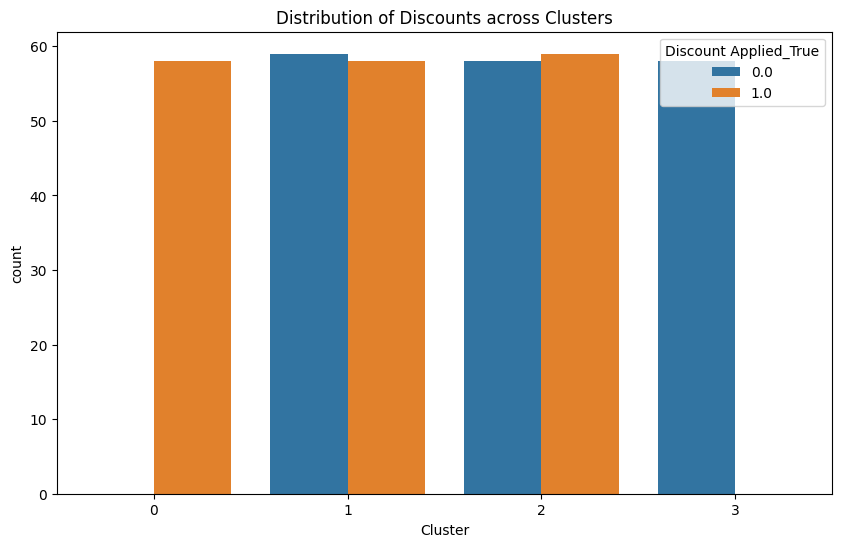

Discount Applied_True          0.0          1.0
Cluster                                        
0                              NaN   499.882759
1                       805.491525   690.389655
2                      1459.772414  1165.035593
3                       446.894828          NaN


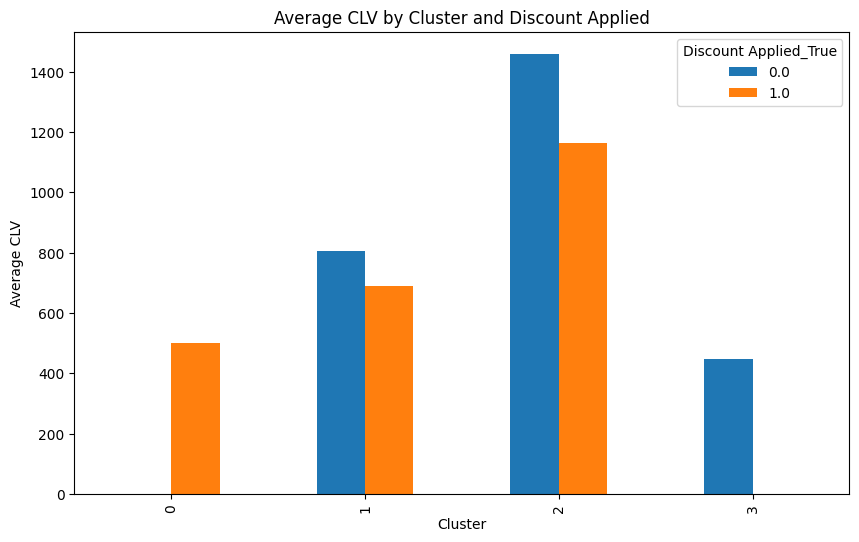

In [412]:
# Remove `Discount Applied_True` from clustering features
clustering_features = data_prepared.drop(columns=["Total Spend", "Discount Applied_True"])

# Re-run K-Means clustering
kmeans = KMeans(n_clusters=4, random_state=2)
data_prepared['Cluster'] = kmeans.fit_predict(clustering_features)

# Check the new distribution of discounts across clusters
plt.figure(figsize=(10, 6))
sns.countplot(x='Cluster', hue='Discount Applied_True', data=data_prepared)
plt.title('Distribution of Discounts across Clusters')
plt.show()

# Calculate average CLV per cluster, by discount application
avg_clv_per_cluster = data_prepared.groupby(['Cluster', 'Discount Applied_True'])['Total Spend'].mean().unstack()
print(avg_clv_per_cluster)

# Visualize the results
avg_clv_per_cluster.plot(kind='bar', figsize=(10, 6))
plt.title('Average CLV by Cluster and Discount Applied')
plt.ylabel('Average CLV')
plt.show()

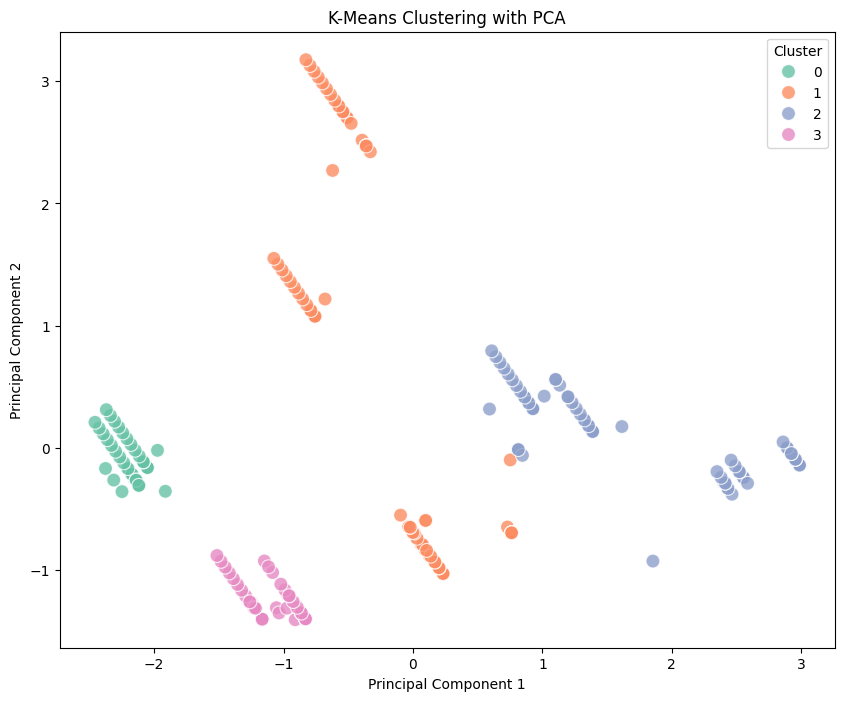

In [413]:
# Reduce dimensions using PCA
pca = PCA(n_components=2)
pca_components = pca.fit_transform(data_prepared.drop(columns=["Total Spend", "Cluster"]))

# Create a DataFrame for the PCA components
pca_df = pd.DataFrame(data=pca_components, columns=['PC1', 'PC2'])
pca_df['Cluster'] = data_prepared['Cluster']

# Plot the clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', palette='Set2', data=pca_df, s=100, alpha=0.8)
plt.title('K-Means Clustering with PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()

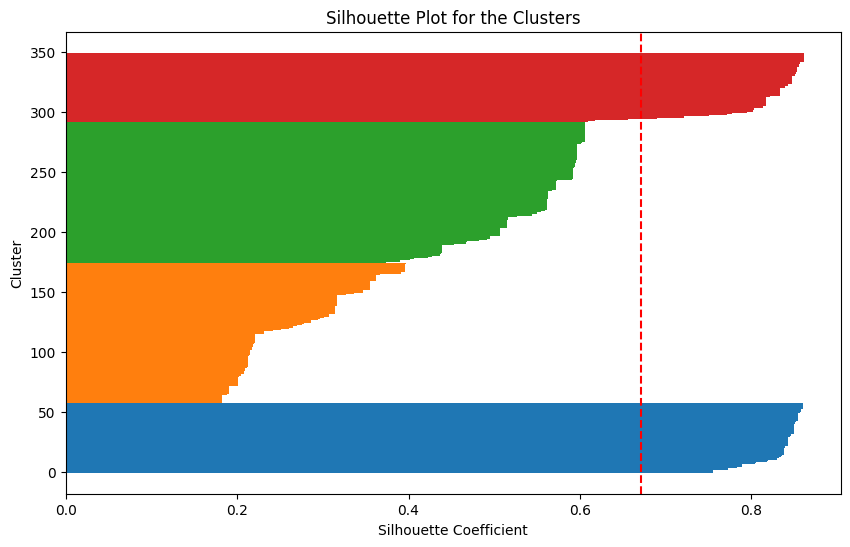

In [414]:
# Calculate silhouette scores for each sample
silhouette_vals = silhouette_samples(data_prepared.drop(columns=["Total Spend", "Cluster"]), data_prepared['Cluster'])

# Create a silhouette plot
plt.figure(figsize=(10, 6))
y_lower, y_upper = 0, 0
for i in range(kmeans.n_clusters):
    cluster_silhouette_vals = silhouette_vals[data_prepared['Cluster'] == i]
    cluster_silhouette_vals.sort()
    y_upper += len(cluster_silhouette_vals)
    plt.barh(range(y_lower, y_upper), cluster_silhouette_vals, height=1.0)
    y_lower += len(cluster_silhouette_vals)

plt.title('Silhouette Plot for the Clusters')
plt.xlabel('Silhouette Coefficient')
plt.ylabel('Cluster')
plt.axvline(x=sil_score, color='red', linestyle='--')
plt.show()

              Age  Items Purchased  Days Since Last Purchase  Gender_Male  \
Cluster                                                                     
0        1.731135        -0.767753                  1.033926     0.000000   
1       -0.419741        -0.226957                  0.273279     0.991453   
2       -0.755372         1.208514                 -0.644364     0.504274   
3        0.639351        -1.212285                 -0.285357     0.000000   

         Membership Type_Gold  Membership Type_Silver  City_Houston  \
Cluster                                                               
0                         0.0                     0.0           0.0   
1                         0.0                     1.0           0.0   
2                         1.0                     0.0           0.0   
3                         0.0                     0.0           1.0   

         City_Los Angeles  City_Miami  City_New York  City_San Francisco  \
Cluster                           

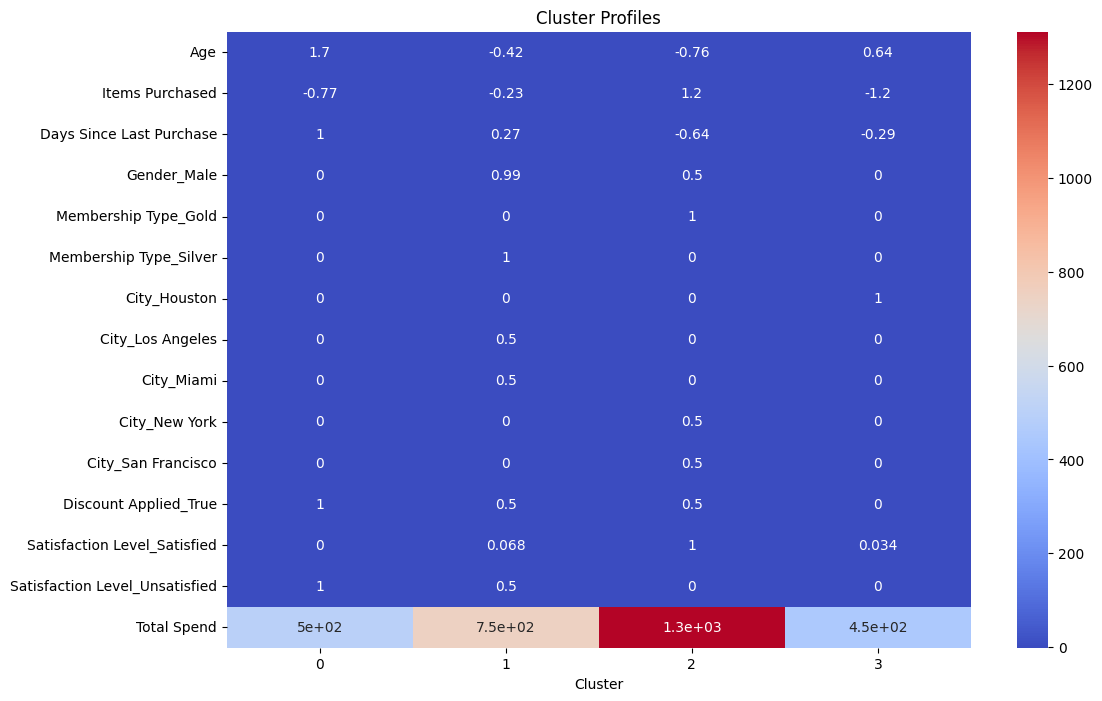

In [415]:
# View Cluster Profiles
cluster_profiles = data_prepared.groupby('Cluster').mean()
print(cluster_profiles)

# Visualize Cluster Profiles
plt.figure(figsize=(12, 8))
sns.heatmap(cluster_profiles.T, cmap='coolwarm', annot=True)
plt.title('Cluster Profiles')
plt.show()


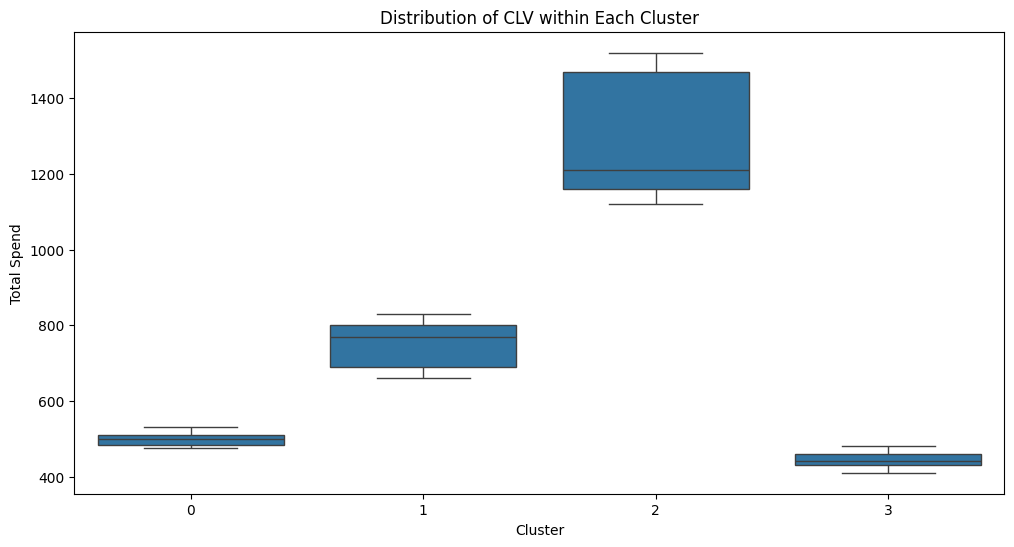

In [416]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Cluster', y='Total Spend', data=data_prepared)
plt.title('Distribution of CLV within Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Total Spend')
plt.show()


#### Identify High-Response Segments for Discounts

Average CLV by Cluster and Discount Applied:
Discount Applied_True          0.0          1.0
Cluster                                        
0                              NaN   499.882759
1                       805.491525   690.389655
2                      1459.772414  1165.035593
3                       446.894828          NaN


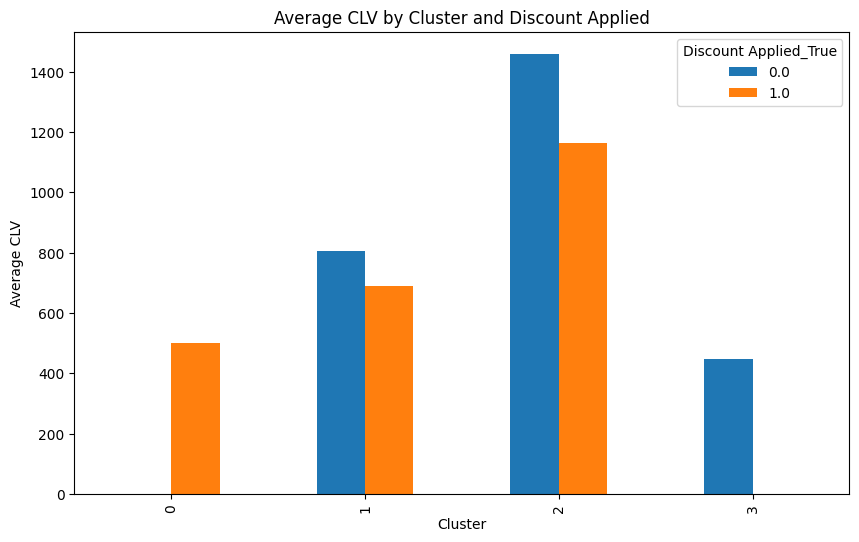

Cluster 2: T-statistic = -46.01, P-value = 0.0000
Cluster 1: T-statistic = -34.02, P-value = 0.0000
Cluster 0: T-statistic = nan, P-value = nan
Cluster 3: T-statistic = nan, P-value = nan


In [418]:
# Assume 'Discount Applied' is a binary column indicating if a discount was applied
# Calculate average CLV for each cluster, grouped by whether a discount was applied
avg_clv_by_discount = data_prepared.groupby(['Cluster', 'Discount Applied_True'])['Total Spend'].mean().unstack()
print("Average CLV by Cluster and Discount Applied:")
print(avg_clv_by_discount)

# Visualize the effect of discounts within each cluster
avg_clv_by_discount.plot(kind='bar', figsize=(10, 6))
plt.title('Average CLV by Cluster and Discount Applied')
plt.ylabel('Average CLV')
plt.show()

# Perform t-tests to check if the difference is significant
from scipy.stats import ttest_ind

for cluster in data_prepared['Cluster'].unique():
    cluster_data = data_prepared[data_prepared['Cluster'] == cluster]
    discounted_clv = cluster_data[cluster_data['Discount Applied_True'] == 1]['Total Spend']
    non_discounted_clv = cluster_data[cluster_data['Discount Applied_True'] == 0]['Total Spend']
    
    t_stat, p_value = ttest_ind(discounted_clv, non_discounted_clv, equal_var=False)
    print(f'Cluster {cluster}: T-statistic = {t_stat:.2f}, P-value = {p_value:.4f}')
